In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

sns.set_style('darkgrid')

df = pd.read_pickle('./food_data_cleaned.pkl')

# C. In-depth Exploratory Data Analysis
Your task is to do an in-depth analysis of the organic vs. non-organic products distribution in the Open Food database. Look for terms such as “bio” and “organic” in the product names.
## Total number of samples by country
Countries with very small sample size should be dropped from this analysis as their results may not be statistically significant.

In [2]:
df.groupby('country').nunique()

,alcohol_by_volume,barcode,calcium_per_hundred,calcium_unit,carbohydrates_per_hundred,carbohydrates_unit,cholesterol_per_hundred,cholesterol_unit,created_at,energy_kcal_per_hundred,...,sugars_per_hundred,sugars_unit,unit,updated_at,vitamin_a_iu_per_hundred,vitamin_a_iu_unit,vitamin_c_ascorbic_acid_per_hundred,vitamin_c_ascorbic_acid_unit,vitamin_d_d2_d3_international_units_per_hundred,vitamin_d_d2_d3_international_units_unit
country,,,,,,,,,,,,,,,,,,,,,
CH,16,19695,140,1,885,1,1,1,19687,723,...,686,1,6,19695,0,1,79,1,0,1
DE,1,832,5,1,322,1,0,1,832,409,...,257,1,3,832,0,1,4,1,0,1
FR,1,45,2,1,39,1,0,1,45,43,...,32,1,4,45,0,1,2,1,0,1
IT,1,229,5,1,143,1,0,1,229,176,...,112,1,3,229,0,1,0,1,0,1
UK,1,1,0,1,1,1,0,1,1,1,...,1,1,1,1,0,1,0,1,0,1
US,1,239760,792,1,5329,1,346,1,330,630,...,3639,1,2,341,1877,1,1012,1,132,1


We will drop all countries but CH and US. We will also exclude rows where product_name_en is 'missing' as we replaced missing values by this value before, and this will not be helpful for analysis

In [3]:
# Remove countries that are not CH or US
df_organic = df[df.country.isin(['CH','US'])]
# Remove useless product names
missing_productname = (df_organic['product_name_en'] == 'missing_productname')
df_organic = df_organic[~missing_productname]

## Organic vs Non-organic
Count the number of organic and non-organic products in each country. Is there a country with a higher percentage of organic products. 

We have to match entire words as after first inquiry, there was product names with PROBIOTICS in them that were matched using simple re.search on bio (not looking for whole words, but terms)

looking also at US and CH law gives us further information

- US law is clear https://www.ams.usda.gov/sites/default/files/media/4012.pdf the term “organic” includes both “organic” and its variants, e.g. “organics,” “organix,” “organik,” “organo-,” “organically,” etc. We have to exclude *made with organic* as this does not indicate necessarily organic product but rather 70% at least of organic ingredients
- CH law is here https://www.bio-suisse.ch/dam/jcr:e3345e56-cc74-44ba-bc17-992a4ea28bd9/def_f_ltiquetage_des_denres_alimentaires_biologiques_2019_2.pdf

***Bio** (biologique) peut figurer dans la dénomination spécifique si au moins 95 % des ingrédients sont d’origine biologique et si les exigences de l’ann. 3 de l’Ordonnance du DEFR sur l’agriculture biologique sont remplies (exceptions: cf. cas particuliers)."*

translates to 

*Organic (biological) may be included in the specific name if at least 95% of the ingredients are of organic origin of organic origin and if the requirements of Ann. 3 of the DEFR Ordinance on Organic Agriculture are met (exceptions: see special cases).*

Additionnally, as i live in Switzerland i know that naturaplan from Coop products are always organic (https://www.coop.ch/en/inspiration-gifts/labels/naturaplan/c/m_1052)

In [4]:
# Using method listed here https://stackoverflow.com/a/15863102
# Create a function to check for the keywords in the product names and return 'Organic' if any are found
def check_organic(name):
    for keyword in organic_keywords:
        if re.search(r"\b" + keyword + r"\b", name, re.IGNORECASE):
            return 'organic'
    return 'non-organic'

# Create a new column called 'organic_flag' with a default value of 'non-organic'
df_organic['organic_flag'] = 'non-organic'

# Define the keywords to look for in the product names
organic_keywords = ['bio','organi(c|cs|k|cally)','naturaplan']

# Apply the function to the 'product_name_en' column and update the 'organic_flag' column
df_organic['organic_flag'] = df_organic['product_name_en'].apply(check_organic)

# Special case of made with organic as per USDA document
df_organic['product_name_en_lower'] = df_organic['product_name_en'].str.lower()
condition = df_organic['product_name_en_lower'].str.contains("made with organic")

# update the 'organic_flag' column to 'non-organic' if made with organic present
df_organic.loc[condition, 'organic_flag'] = 'non-organic'

df_organic[df_organic['organic_flag']=='organic'].loc[:,('product_name_en','organic_flag','country')].sample(5)

,product_name_en,organic_flag,country
id,,,
173292,ORGANICS ROASTED GARLIC BREAD,organic,US
71739,"AMY'S, COOL SCOOPS, ORGANIC COCONUT MILK NON-D...",organic,US
81244,ORGANIC SPROUTED RISOTTO,organic,US
76498,ORGANIC ELBOW MACARONI & CHEESE PASTA WITH CHE...,organic,US
260445,ORGANIC ROASTED RED PEPPER SOUP,organic,US


Here we drop duplicates based on product name, because we don't want to be double counting products in the distributions that follows.

In [5]:
df_organic = df_organic.drop_duplicates(subset='product_name_en', keep='first')

## Distributions of macronutrients
Compare the distributions of the macronutrients between organic and non-organic products in each country.
list of macronutrients from https://en.wikipedia.org/wiki/List_of_macronutrients is carbs, proteins, fat, fiber and alcohol.

In [6]:
macronutrients = ['carbohydrates_per_hundred',
                  'protein_per_hundred',
                  'fat_per_hundred',                  
                 ]                  

### Boxplots Organic vs NonOrganic in CH and US

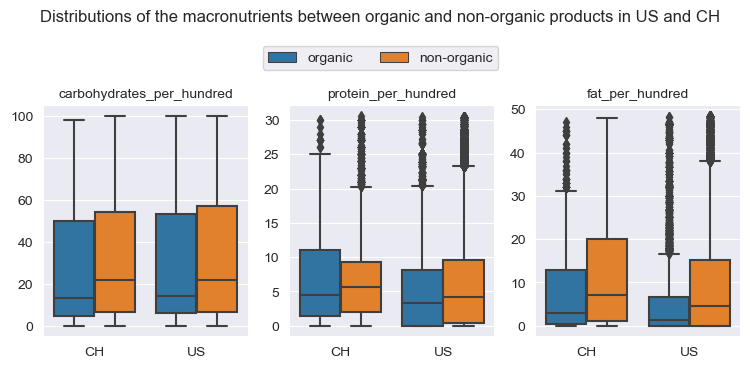

In [7]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(macronutrients), figsize=(9, 3))

for i, column in enumerate(macronutrients):
    ax = axes[i]
    # Boxplot for each country, color by organic and non-organic
    sns.boxplot(x='country',
                y=column,
                hue='organic_flag',
                data=df_organic,
                ax=ax
               )
    
    ax.set_title(column,fontdict={'fontsize': 10})           
    ax.legend_.remove()
    ax.set_ylabel('')
    ax.set_xlabel('')
    
# Creating a single legend above subplots
# ref https://stackoverflow.com/a/46921590
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
# Adding overall title
fig.suptitle('Distributions of the macronutrients between organic and non-organic products in US and CH', y=1.2)

plt.show()

We can observe from boxplot that 
* Carbs have approximatively similar distribution, slight higher both in organic and non-organic products in the US
* Protein and fat have still a lot of outliers in them as we chose zscore for those columns (it was less restrictive).
* Protein is more spread for CH in organic products vs CH non organic products and fat behaves opposite way. Organic products seems to have overall less fat and more proteins in CH. It is also true for fat in the US, not necessarily for proteins.

### Investigating CH with density plot

As an example we will have a closer look at organic vs non organic in CH products only using a kernel density estimate (KDE) from seaborn library to see more precisely by macronutrients.

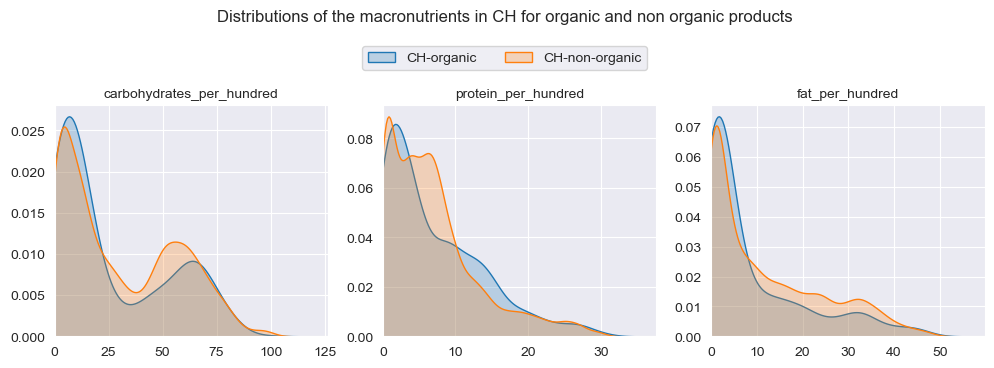

In [46]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(macronutrients), figsize=(12, 3))

country = 'CH'
# Iterate over the columns in macronutrients list
for i, column in enumerate(macronutrients):
    ax = axes[i]
    # Plot kdeplot for each level of 'organic_flag' and 'country'
    for organic_flag in df_organic['organic_flag'].unique():
            
        # Filter to a specific country and organic_flag
        kdeplot_filter = (df_organic['country']==country) & (df_organic['organic_flag']==organic_flag)
            
        sns.kdeplot(data=df_organic[kdeplot_filter][column],
                    ax=ax,
                    shade=True,
                    label=f"{country}-{organic_flag}"
                   )
    # Add title to each subplot
    ax.set_title(column, fontdict={'fontsize': 10})    
    ax.set_ylabel('')
    # Have all x axis start at 0, as we have no negative nutritional values
    ax.set_xlim(left=0)
    ax.set_xlabel('')    

# Creating a legend above subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

# Adding overall title
fig.suptitle('Distributions of the macronutrients in CH for organic and non organic products', y=1.2)

plt.show()

We can observe that
* Non organic products in CH are generally more present in the region over 25-60g carbs per hundred.
* Organic  products are more present in the 10-20g of proteins.
* Fat products with more than 10g of fats are visibly around a 1/4-1/3 rarer in organic products distribution vs non organic.

# D. Text Data
## Longest ingredients list
Find the product with the longest ingredients list, i.e. the largest number of ingredients. Print the product name and its ingredient list

### Context
To be honest, the complexity of this question left me feeling lost.

For instance "CHERRIES, WATER, SUGAR, FOOD STARCH-MODIFIED (CORN AND ASCORBIC ACID (VITAMIN C) TO MAINTAIN COLOR, RED 40 COLOR."

In this case 
* CHERRIES, WATER, SUGAR are straigthforwardly 3 different ingredients
* FOOD STARCH-MODIFIED (CORN AND ASCORBIC ACID (VITAMIN C) TO MAINTAIN COLOR should be modified to FOOD STARCH-MODIFIED CORN AND ASCORBIC ACID (VITAMIN C)
* We see the case of synonyms rising were VITAMIN C = ASCORBIC ACID, and of extracting information out parentheses

https://www.kaggle.com/code/db102291/ingredient-list-parsing-with-nlp this was a big inspiration of what follows

### Removing duplicates
We reduce dataframe to non missing values and remove duplicates based on ingredients_en.

In [10]:
df_ingredients = df.copy()

In [11]:
missing_ingredients = (df['ingredients_en'] == 'missing_ingredients')
df_ingredients = df_ingredients[~missing_ingredients]
df_ingredients = df_ingredients.drop_duplicates(subset='ingredients_en', keep='first')

### Removing obvious error entries

We will first address case of those examples where a bracket such as ( or [ is opened but never closed

Examples 
* 8046	CRUST (ENRICHED WHEAT FLOUR [FLOUR NIACIN IRON
* 8047	steamed basmati rice (98%), sunflower oil)

We will define a function to measure how many rows are concerned and whether we can remove them to simplify analysis

In [12]:
def check_unbalanced_brackets(string) -> bool:
    '''
    Function expects a string as input and returns a boolean value
    checks if all open brackets are correctly open and closed
    returns True if brackets are not properly balanced
    
    example1 = "CRUST (ENRICHED WHEAT FLOUR [FLOUR NIACIN IRON" > True
    example2 = "CRUST (ENRICHED WHEAT FLOUR [FLOUR NIACIN IRON])" > False
    example3 = "CRUST (ENRICHED WHEAT FLOUR [FLOUR NIACIN IRON)" > True

    '''
    # Initialize an empty open_brackets_stack 
    # where we will store open brackets characters we find
    open_brackets_stack = []
    
    # Create a dictionnary where we match close brackets against their open bracket
    opposite_brackets = {')': '(', ']': '[', '}': '{'}
    
    for char in string:
        # If the character is an open bracket, add it to the open_brackets_stack
        if char in '([{':
            open_brackets_stack.append(char)
        # If the character is a close bracket
        elif char in ')]}':
            # Check if open_brackets_stack is not empty
            if len(open_brackets_stack) > 0:
                # If there are, check if last open bracket in open_brackets_stack matches close bracket
                if open_brackets_stack[-1] == opposite_brackets[char]:
                    # If it does, remove the last open bracket added to the open_brackets_stack
                    open_brackets_stack.pop()
                else:
                    # If closed bracket does not match last open bracket, we flag ingredient_list as unparsable 
                    return True
            else:
                # If there is no open bracket opened, we flag ingredient_list as unparsable 
                return True

    # If there are still open brackets left after matching associated close brackets, we flag ingredient_list as unparsable 
    if len(open_brackets_stack) > 0:
        return True
    else:
        return False

Based on this function, we will count number of unique occurences of ingredients_en that we deem too complex to parse at this stage.

In [13]:
# Applying custom function to create new boolean column
df_ingredients['ingredients_unparsable'] = df_ingredients['ingredients_en'].apply(check_unbalanced_brackets)
print('We will remove',
      df_ingredients[df_ingredients['ingredients_unparsable'] == True].shape[0],
      'ingredients out of',
      df_ingredients.shape[0])

We will remove 8229 ingredients out of 187038


In [14]:
# Applying boolean mask
df_ingredients = df_ingredients[df_ingredients['ingredients_unparsable'] == False]

### Cleaning ingredients_en
We will remove different parts of the ingredients_en so as to standardize for analysis. 

* Defining df_ingredients['ingredients'] as clean version of df_ingredients['ingredients_en']
* Putting everything to lowercase.
* We now standardize all open and close brackets to simplfy custom functions and follow up code. We can do this as we know from running custom function 'check_unbalanced_brackets' that all brackets are balanced and thus equivalent.
* Our universal separator to distinguish ingredients will be comma. So we replace anything that acts as a separator by a comma.

In [15]:
# Replace all open and close brackets by ( or )
df_ingredients['ingredients'] = df_ingredients['ingredients_en'].replace('[\{\[]', '(', regex=True)
df_ingredients['ingredients'] = df_ingredients['ingredients'].replace('[\}\]]', ')', regex=True)
# Lowercase
df_ingredients['ingredients'] = df_ingredients['ingredients'].str.lower()

Removing percentage in indication as in *honey (3.0%)* so it becomes *honey*.

In [16]:
# The part ,?\.?;? makes the '.' or ',' or ';' character optionals
df_ingredients['ingredients'] = df_ingredients['ingredients'].apply(lambda x: re.sub(r'\(\d*,?.?;?\d*%\)', '', x))

Removing new line characters \r carriage return and \n line break 

In [17]:
df_ingredients['ingredients'] = df_ingredients['ingredients'].apply(lambda x: re.sub(r'[\r\n]+', '', x))

At this stage, we will remove or replace common phrases that act as separator as in *pressed oranges and pureed bananas*, a good candidate to become *pressed oranges, pureed bananas*, or punctuation that acts as separator such as point or semicolon. Also converting ' and ' or ';' as separator ','.
'enriched with'

In [18]:
df_ingredients['ingredients'] = df_ingredients['ingredients'].apply(lambda x: re.sub(r'( and |&|\s\.|\.\s|;|-)', ',', x))

### Complexity of ingredients list

Our goal now is to split remaining records into lists of sub ingredients where we are able to address nested ingredients.

We introduce the notion of the complexity of an ingredient list, defined as the maximum of the complexity of each sub ingredient in list.

The complexity of each sub ingredient is given by the maximum number of nested '()' we find in sub ingredient. Example

* complexity of 0 : romaine lettuce 
* complexity of 1 : ()  - pepperoncini **(** pepperoncini, water, salt **)**
* complexity of 2 : (()) - feta cheese **(** pasteurized milk, salt **(** sodium **)**, cheese culture **)**

As we know brackets are now balanced, we can define a custom function that counts encountered non closed open brackets and determines complexity based on this.

In [19]:
def complexity(ingredient):
    '''
    Input : a string
    Returns an integer
    '''
    complexity = 0
    max_complexity = 0
    for char in ingredient:
        ' Encounters open bracket
        if char == '(':
            complexity += 1
        ' Encounters close bracket
        elif char == ')':
            complexity -= 1
        max_complexity = max(max_complexity, complexity)
    return max_complexity

We define a custom function to split ingredient list into a list of sub ingredients.

In [20]:
def parse_ingredients_list(ingredients_list):
    '''
    Input : a string
    Returns : a list based on the number of nested ().
    Everytime a comma is found outside an open and non-closed  '(' an element is added to the list    
    
    Example
    'romaine lettuce , pepperoncini (pepperoncini, water, salt), feta cheese (pasteurized milk, salt (sodium), cheese culture)'
    becomes 
    ['romaine lettuce ',
    ' pepperoncini (pepperoncini, water, salt)',
    ' feta cheese (pasteurized milk, salt (sodium), cheese culture)']
    
    '''
    
    # Create a count to keep track of open brackets
    open_brackets_count = 0
    # Create a variable to store the current substring
    current_sub_ingredient = ""
    # Create a list to store the final result
    result = []
    
    # Iterate over each character in the string
    for i, char in enumerate(ingredients_list):                           
        
        # If the character is an open bracket, add it to open_brackets_stack 
        if char == '(':
            open_brackets_count += 1
        # If the character is a close bracket, last element added to open_brackets_stack
        elif char == ')':
            open_brackets_count -= 1
        
        # The only time we want to stop adding character and reset substring
        # when we find a ',' that is not inside a unclosed open bracket
        if (open_brackets_count == 0) and (char == ','):
            result.append(current_sub_ingredient)
            current_sub_ingredient = ""
        else:
            current_sub_ingredient += char
            # Special case when we reach last character in string
            if i == len(ingredients_list) - 1:            
                result.append(current_sub_ingredient)                 
                
    return result

We now create a new dataframe column that converts column 'ingredients' into a list of ingredients.

Ingredients in that list have different level of complexity. And we want to identify what level of complexity are reached and at what volumes.

In [21]:
df_ingredients['ingredients_list'] = df_ingredients['ingredients'].apply(parse_ingredients_list)

Creating a custom function that calculates the complexity of an ingredient list, defined as the maximum of the complexity of each sub ingredient in list.

In [22]:
def compute_complexity(ingredients_list):
    '''
    Input : a list of ingredient
    Returns : an integer, which matches the highest complexity reach in ingredients_list
    i.e. the maximum number of open/closed brackets () nested in an ingredient 
    
    Example
    ['romaine lettuce ',
    ' pepperoncini (pepperoncini, water, salt)',
    ' feta cheese (pasteurized milk, salt (sodium), cheese culture)']
    This list if of complexity 2 due to last element.
    '''
    max_complexity_list = 0
    
    for ingredient in ingredients_list:
        complexity_list = complexity(ingredient)
        max_complexity_list = max(complexity_list, max_complexity_list)
    return max_complexity_list

In [23]:
df_ingredients['ingredients_complexity'] = df_ingredients['ingredients_list'].apply(compute_complexity)

In [24]:
df_ingredients.groupby('ingredients_complexity')['id'].count()

ingredients_complexity
0    50269
1    90826
2    32777
3     4620
4      301
5       15
6        1
Name: id, dtype: int64

The vast majority of ingredients_list have complexity levels below 3, so we will concentrate on this cases. I chose to exclude cases above 3 as they seem too complex and prone to errors.

In [25]:
print('We will remove',
      df_ingredients[df_ingredients['ingredients_complexity'] > 2].shape[0],
      'ingredients out of',
      df_ingredients.shape[0])

We will remove 4937 ingredients out of 178809


In [26]:
df_ingredients = df_ingredients[df_ingredients['ingredients_complexity'] <= 2]

### Case ingredients_list complexity is 0

We define a parent ingredient as an ingredient in a ingredient list which can be made of other ingredients.
* in *salt (sodium)* **salt** in the parent ingredient
* in *pepperoncini (pepperoncini, water, salt)* **pepperoncini** is the parent ingredient

Case ingredients_list complexity is 0 is the easiest one as it means all ingredients in ingredients list are parent ingredients. Examples
* ['Latte scremato pastorizzato', ' panna pastorizzata', ' sale da cucina', ' colture', ' caglio microbico.']
* ['100% organic coconut water ']

In this case, it is only a matter of removing punctuation, case, special characters.

### Case ingredients_list complexity is 1

Two different cases : BOM for Bill Of Materials, or Synonym

**Case 1 : BOM**. Parent Children. Example *reduced fat cheddar cheese (pasteurized milk, cheese cultures, salt, enzymes)*.
This is a case of a parent ingredient made of children ingredients. In this case, we are going to replace *reduced fat cheddar cheese*  by *pasteurized milk, cheese cultures, salt, enzymes*. 1 parent ingredient in this case will translate to 4 children ingredients.


**Case 2 : Synonym**. Example ascorbic acid (vitamin c)
In some cases, () are also used to specify Country of Origin *'70% Sardines (Sardina pilchardus, caught in the North-East Atlantic)'*. 
The synonym problem is a very complex one for multiple reasons. 

Lets take the case of additives like E100	curcumin. Considering E100 will be correctly written and not E 100 or E-100. It can be written as 
    * E100 (curcumin)
    * curcumin (E100)
    * curcumin
    * E100
* One way I can think about solving this would be to look a list of parent ingredients and look at the frequency. If a element is vastly more frequent than its synonym, in example *E100 (curcumin)*, lets say *E100* is vastly more used, i will always replace *curcumin* by *E100* or *E100 (curcumin)* and *curcumin(E100)* both by E100.
* This implies that the parent list is fully cleaned so that ' curcumin' and 'curcumin' are counting towards same frequency.
* This also open an area for error by chaining replacement
    * To follow up on example, what do we do about 'sauce (curcumin)' do we chain it and replace by 'E100'
    
We chose not to tackle it as the moment and simply replace  *E100 (curcumin)* by *E100* and *curcumin (E100)* by *curcumin*, or in other words extract everything before open parenthesis.


**Using a dictionnary** We chose to use a dictionnary to classify ingredients_list.

In [27]:
def classify_ingredients_list(ingredients_list):
    """
    This function takes a list as an input and transforms it into a dictionary 
    where each ingredient in the list is annotated
        'bom' :  if the ingredient contains '(', and at least one ','
        'synonym' :  if the ingredient contains '(', but no ','
        'parent' : otherwise
    """
    # Initialize an empty dictionary to store the results
    result_dict = {}
    
    # Iterate through the input list
    for ingredient in ingredients_list:
        # Check if the ingredient contains at least one ','
        if ',' in ingredient:
            result_dict[ingredient] = 'bom'
        # Check if remaining ingredient contains '('
        elif '(' in ingredient:
            result_dict[ingredient] = 'synonym'
        # If the ingredient does not contain '(', or ','
        else:
            result_dict[ingredient] = 'parent'
    
    return result_dict

# Test the function
ingredients_list = ['apple (fruit)', 'orange (fruit, citrus)', 'banana']
print(classify_ingredients_list(ingredients_list))
# Output: {'apple (fruit)': 'synonym', 'orange (fruit, citrus)': 'bom', 'banana': 'parent'}

{'apple (fruit)': 'synonym', 'orange (fruit, citrus)': 'bom', 'banana': 'parent'}


### Case ingredients_list complexity is 2

The complexity of an ingredient list is given by the maximum complexity found in its ingredients.

* To convert an ingredient list of complexity 2 to 1, we only have to transform **all ingredients of complexity 2** to a lower level of complexity.

* Example in *spices (maltodextrin, spices (turmeric, coriander), acidifier (citric acid))*
    * replacing *spices (turmeric, coriander)* by *turmeric, coriander*
    * replacing *acidifier (citric acid)* by *acidifier* . We chose for this case of complexity = 2, to accept some risk of error and to simplify the case of synonyms by always take string before parenthesis, considering in most cases what is parenthesis brackets is a description or added information of the inside.
    * Exploding BOMs, replacing synonyms. Ingredient list becomes *spices (turmeric, coriander)*. We are now at complexity 1
    * Final explosion and go to complexity 0 and have list of parent ingredients *turmeric, coriander*
    
We define a custom function that reproduces this behavior based on a dictionnary as obtain in function classify_ingredients_list

In [28]:
def simplify_ingredients(ingredient_dict):
    """
    This function takes a dictionnary as an input and transforms it into a list 
    in which each key of dictionnary is treated based on values 'parent', 'synonym' or 'bom
        - for 'parent' we take key of dictionnary
        - for 'synonym' we take string before parenthesis
        example replacing 'acidifier (citric acid)' by 'acidifier'
        - for 'bom', we replace outside by inside of parenthesis
        example 'spices (turmeric, coriander)' by 'turmeric, coriander'
        
    >> Output is a list
    ingredients_dict = {'maltodextrin' : 'parent',
                        'acidifier (citric acid)': 'synonym',
                        'spices (turmeric, coriander)'   : 'bom'}
    becomes a list reworked_ingredient = ['maltodextrin','acidifier','turmeric','coriander']
    """
    
    try:
        reworked_ingredient = []

        for key, value in ingredient_dict.items():                

            # Easiest case
            if value == 'parent':
                reworked_ingredient.append(key)

            # Synonyme case, we keep string before open parenthesis
            elif value == 'synonym':                    
                reworked_ingredient.append(key.split("(")[0])

            # BOM case, we explode BOM by separating each ingredient
            elif value == 'bom':
                bom_elements = key.split("(")[1].split(")")[0]
                for sub_ingredient in bom_elements.split(","):
                    reworked_ingredient.append(sub_ingredient)

    except:
        print("Error: ", ingredient_dict)

    return reworked_ingredient

In [29]:
def reduce_complexity(ingredient_list):
    '''
    Takes as an input an ingredient_list of complexity 2
    and returns it as an ingredient_list of complexity less than 2
    
    example ['preparation of spices (maltodextrin, salt spices (garlic powder, turmeric, coriander), acidifier (citric acid))']
    becomes  ['maltodextrin', 'garlic powder', 'turmeric', 'coriander', 'acidifier']    
    '''
    # Iterate through each ingredient in the ingredient list
    for index, ingredient in enumerate(ingredient_list):        
        
        # Check if the complexity of the ingredient is equal to 2           
        if complexity(ingredient) == 2:           

            # To reduce complexity to 1, we have to extract the substring within ()
            # We did not make \) as last charcter with $, as sometimes ingredient ends with '.' or some text
            # We take a shortcut here by extracting all that is within ().
            substring = re.search(r'\((.*)\)', ingredient).group(1)
            
            # Run the parse_ingredients_list function on the substring to transform it into a sublist
            sublist = parse_ingredients_list(substring)
            
            # Run the classify_ingredients_list function on the sublist to convert it to a dictionary
            ingredient_dict = classify_ingredients_list(sublist)     
                      
            # Convert dictionnary back to a list
            reworked_ingredient = simplify_ingredients(ingredient_dict)
            
            # We take ingredient of complexity 2 out of list and replace it by reworked_ingredient
            ingredient_list.pop(index)
            ingredient_list[index:index] = reworked_ingredient
       
    return ingredient_list

Apply custom function to rows where ingredient_complexity is 2

In [30]:
complexity_is_two = (df_ingredients['ingredients_complexity'] == 2)
df_ingredients.loc[complexity_is_two, 'ingredients_list'] = df_ingredients.loc[complexity_is_two, 'ingredients_list'].apply(reduce_complexity)

We recompute complexity 

In [31]:
df_ingredients['ingredients_complexity'] = df_ingredients['ingredients_list'].apply(compute_complexity)

We can now also apply our dictionnary function to all rows in dataframe, as it works only when ingredients_complexity is lower or equal to 1

In [32]:
df_ingredients['ingredients_dict'] = df_ingredients['ingredients_list'].apply(classify_ingredients_list)

### Single out ingredients
We will now rework each elements in 'parent ingredients' list

In [33]:
df_ingredients['parents_ingredients'] = df_ingredients['ingredients_dict'].apply(simplify_ingredients)

Error:  {'crushed tomatoes ': 'parent', ' smoked bacon ': 'parent', ' pork (eu)': 'synonym', ' salt': 'parent', ' spices': 'parent', ' flavouring), onions , tomato semi,concentrate, water, olive oil , sugar, rice starch, parsley , salt, garlic, acidity corrector: lactic acid, red pepper , rosemary, bay leaf.': 'bom'}


Our simplify_ingredients is not working only on dictionnary due to this part 'flavouring),'. As this is only one error, we consider it is okay.

We now iterate within parents_ingredients lists and apply regex transformation for each ingredient within that list

In [34]:
for index, row in df_ingredients.iterrows():
    # Get the current list of ingredients for the current row
    current_ingredient_list = row['parents_ingredients']
    # print(len(current_ingredient_list),current_ingredient_list)
    
    # Iterate over the current list of ingredients
    for i, ingredient in enumerate(current_ingredient_list):
        
        # Remove anything before ":" such as "contains less than 2% of :"
        # Check if the ingredient string contains a colon
        if ":" in ingredient:           
            new_ingredient = ingredient.split(":")[1]        
        else:
            new_ingredient = ingredient
        
        # Remove anything between contains and a %
        new_ingredient = re.sub(r'contains.*\d*[,.?;]?\d*%\s*', '', new_ingredient)
        
        # Remove anything after ' to ' as in 
        #'calcium disodium edta to preserve flavor'
        new_ingredient = re.sub(r' to .*', '', new_ingredient)
        
        # Strip special characters
        new_ingredient = re.sub(r'[^\w\s]', '', new_ingredient)
        
        # Strip all numerical values
        new_ingredient = re.sub(r'\d+\.\d+|\d+', '', new_ingredient)
        
        # Strip whitespace from the beginning and end
        new_ingredient = re.sub(r'^\s+|\s+$', '', new_ingredient)
        
        # Add the cleaned ingredient to the current list
        current_ingredient_list[i] = new_ingredient
    
    df_ingredients.at[index, 'parents_ingredients'] = current_ingredient_list

We create a new column called 'unique_ingredients' that contains the unique elements from 'parents_ingredients' lists. The conversion to an iterable with set() makes elements unique and we convert set back to a list with list()

In [35]:
df_ingredients['unique_ingredients'] = df_ingredients['parents_ingredients'].apply(lambda x: list(set(x)))
df_ingredients['number_unique_ingredients'] = df_ingredients['unique_ingredients'].apply(lambda x: len(x))

### Getting longest list
We will now get longest list of unique ingredients. We try and maximize readability of results using different print statement and joining lists

In [37]:
# Increase maximum column width to display full column in Jupyter Lab
pd.options.display.max_colwidth = 1000000

longest_ingredients_list = df_ingredients.sort_values(by='number_unique_ingredients', ascending=False).head(1)
print(longest_ingredients_list['product_name_en'])
print(longest_ingredients_list['number_unique_ingredients'])
print(longest_ingredients_list['ingredients_en'])
print('Long ingredient list : ',', '.join(longest_ingredients_list['ingredients_list'].astype(str)))
print('Unique ingredients list : ',', '.join(longest_ingredients_list['unique_ingredients'].astype(str)))

id
255075    MINI DECADENT DESSERTS
Name: product_name_en, dtype: object
id
255075    118
Name: number_unique_ingredients, dtype: int64
id
255075    WATER, SUGAR, PALM OIL, HIGH FRUCTOSE CORN SYRUP, CORN SYRUP, COCOA (PROCESSED WITH ALKALI), MONO AND DIGLYCERIDES, POLYSORBATE 60, SALT, SOY LECITHIN, POTASSIUM SORBATE, CITRIC ACID, NATURAL AND ARTIFICIAL FLAVORS, PASTEURIZED MILK AND CREAM, CHEESE CULTURE, CAROB BEAN, XANTHAN GUM, GUAR GUM, COCONUT (PRESERVED WITH SODIUM METABISULFITE), DEXTROSE, CORN SYRUP SOLIDS, DRY EGG WHITES, WHEAT STARCH, FLOUR, NIACIN, REDUCED IRON, THIAMINE MONONITRATE, RIBOFLAVIN, FOLIC ACID, FOOD STARCH - MODIFIED, CORN STARCH, DRY WHEY, SOY FLOUR, MODIFIED CORN STARCH, SOYBEAN OIL, WHEY, BAKING SODA, SODIUM ALUMINUM PHOSPHATE, VITAL WHEAT GLUTEN, SORBITAN MONOSTEARATE, CALCIUM ACETATE, SODIUM STEAROYL LACTYLATE, NONFAT MILK, SODIUM BICARBONATE, WHOLE EGGS, FULLY REFINED SOYBEAN OIL, WALNUTS, POWDERED EGG YOLKS, NONFAT DRY MILK, POWDERED EGG WHITE, BAKING SODA

Our longest unique ingredient list is named 'MINI DECADENT DESSERTS' https://www.foodrepo.org/en/products/255075
Our final list we see that special case of 'Mono- and diglycerides' that is splitted based on 'and'. We can also see that the longest list of ingredients is relatively straighforward with not a lot of parenthesis.

## Shortest ingredients list
Find the products with the shortest ingredients list, i.e. the fewest ingredients. Display some examples and comment on your observation.
This will be easier to display than longest ingredient list

In [38]:
columns_kept = ('product_name_en','ingredients_en','parents_ingredients','unique_ingredients','number_unique_ingredients')
df_ingredients.loc[:,columns_kept].sort_values(by='number_unique_ingredients', ascending=False).tail(10)                      

,product_name_en,ingredients_en,parents_ingredients,unique_ingredients,number_unique_ingredients
id,,,,,
89870,JUMBO OATS,PURE SCOTTISH PORRIDGE OATS 100%,[pure scottish porridge oats],[pure scottish porridge oats],1
287716,OAK AGED BALSAMIC VINEGAR,AGED CALIFORNIA BALSAMIC VINEGAR.,[aged california balsamic vinegar],[aged california balsamic vinegar],1
237890,ORGANIC WHOLE GRAIN CORN FLOUR,WHOLE GRAIN ORGANIC CORN.,[whole grain organic corn],[whole grain organic corn],1
313465,PREMIUM BLUEBERRIES,PREMIUM BLUEBERRIES,[premium blueberries],[premium blueberries],1
237902,WHOLE GRAIN TEFF,WHOLE GRAIN TEFF,[whole grain teff],[whole grain teff],1
278681,ORGANIC YOUNG JACKFRUIT,ORGANIC YOUNG JACKFRUIT.,[organic young jackfruit],[organic young jackfruit],1
37306,Pomegranate juice,pomegranate juice,[pomegranate juice],[pomegranate juice],1
237903,BUTTERMILK POWDER,DRIED SWEET CREAM BUTTERMILK (MILK).,[dried sweet cream buttermilk],[dried sweet cream buttermilk],1
287725,CLOVES WHOLE,CLOVES WHOLE,[cloves whole],[cloves whole],1


As it could be expectedthe shortest ingredients list contain one unique ingredient, such as 'aged california balsamic vinegar' or 'whole grain organic corn'. They contain some description of what the single ingredient is like 'dried' or 'aged' or 'organic'. It could be argue to further simplifies and consider that 'aged vinegar' could be 'vinegar' but it would get very complex.

## Most frequent ingredients
Which are the most frequent ingredients in products? You will also choose an appropriate method to visualize your findings.

Now that we have clean and singled out ingredients into a column called unique_ingredients, we will explode list in each row it and insert it as a new series in a new dataframe.
This will enable us to count frequency of each unique ingredient, and establish what ingredients are more uniquely present in each food product.

In [39]:
# Creating a new dataframe called df_ingredients_freq 
# to store the unique ingredients from the original dataframe df_ingredients

# Exploding the 'unique_ingredients' column in the df_ingredients dataframe 
# and storing the result in a new pandas Series called 'unique_ingredients'
unique_ingredients = df_ingredients.explode('unique_ingredients', ignore_index=True)['unique_ingredients']

# Creating a new dataframe df_ingredients_freq and storing the unique_ingredients Series
df_ingredients_freq = pd.DataFrame({'ingredient': unique_ingredients})
df_ingredients_freq.size

2830156

We now reduce this data frame to unique ingredient accross all food products. After having adding count we can take out duplicates, and add the share of total frequency for a given food product frequency

In [40]:
# Adding a column to df_ingredients_freq to store the frequency of each ingredient
df_ingredients_freq['frequency'] = df_ingredients_freq.groupby('ingredient')['ingredient'].transform('count')

# Removing duplicate rows
df_ingredients_freq.drop_duplicates(inplace=True)

# Sorting by frequency
df_ingredients_freq.sort_values(by='frequency', ascending=False, inplace=True)

# Adding a column to store the share of frequency across ingredients
total_frequency = df_ingredients_freq['frequency'].sum()

df_ingredients_freq['share'] = 100*df_ingredients_freq['frequency'] / total_frequency

We had a final cleaning step to remove potential errors where ingredients has less than 2 characters

In [41]:
# Create a boolean mask True when ingredient is shorter than 2 charcater
mask = df_ingredients_freq['ingredient'].str.len() <= 2
print('Removing ', df_ingredients_freq[mask].shape[0], ' rows with incorrect ingredients',
     'out of ' , df_ingredients_freq.shape[0])

# Drop the rows that match the mask
df_ingredients_freq = df_ingredients_freq[~mask]

Removing  132  rows with incorrect ingredients out of  67287


We can now plot our dataframe on a barplot. 

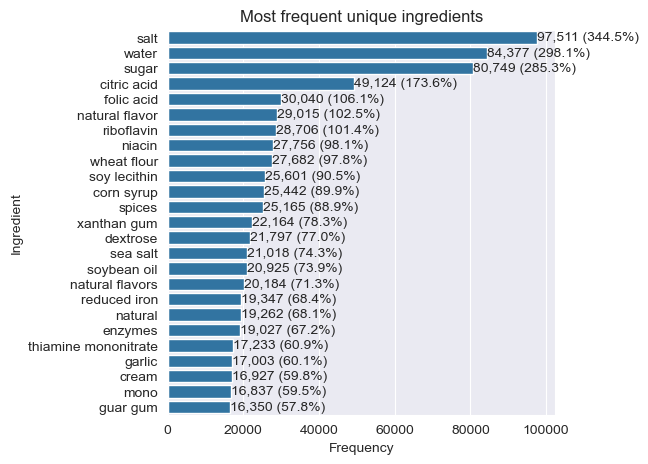

In [42]:
df_plot = df_ingredients_freq.nlargest(25,'frequency')

fig, axes = plt.subplots(figsize=(5, 5))

# Create a horizontal bar chart
sns.barplot(x='frequency',
            y='ingredient',
            data=df_plot,
            orient='h',
            color='#1f77b4'
           )

plt.xlabel('Frequency')
plt.ylabel('Ingredient')

plt.title('Most frequent unique ingredients')

values = df_plot['frequency'].values
proportions = 100* df_plot['share'].values
labels = [f'{p[0]:,} ({p[1]:.1f}%)' for p in zip(values, proportions)]
axes.bar_label(container=axes.containers[0], labels=labels)

plt.yticks(fontsize=10)

plt.show()

We can see most frequent are salt, water, sugar by a large margin, followed by citric acid and folic acid.
We see errors that would need to retreated such as 'natural flavor', 'mono', 'natural'